#Project: HummingFace

Léo Dupire & Mateus Aragão

##Data

In [40]:
%cd ./Desktop/HummingFace

[Errno 2] No such file or directory: './Desktop/HummingFace'
/Users/leodupire/Desktop/HummingFace


In [41]:
#@title Imports
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import signal
from scipy.io import wavfile
from pydub import AudioSegment
from IPython.display import Audio, display

###Spectrogram Functions (explore MFCCs)

In [42]:
# Convert raw audio into spectrogram
def spectrogramify(instance, phase, nperseg=1000):
  # instance: record name
  # phase: train, val, or test
  dir = "./nsynth-" + str(phase) + "/audio/" + str(instance) + ".wav"
  sample_rate, samples = wavfile.read(dir)
  frequencies, times, spectrogram = signal.stft(samples, fs=sample_rate, nperseg=nperseg)

  return sample_rate, frequencies, times, spectrogram


# Display spectrogram
def show_spectro(times, frequencies, spectrogram):
  f = plt.figure()
  f.set_figwidth(5)
  f.set_figheight(3)

  plt.pcolormesh(times, frequencies, np.abs(spectrogram))
  plt.ylabel('Frequency [Hz]')
  plt.xlabel('Time [sec]')
  plt.ylim([0, 2000])
  plt.show()


# Generate .wav file from spectrogram
def spectro_to_wav(spectrogram, sample_rate = 16000):
  _, gen = signal.istft(spectrogram, sample_rate)
  wavfile.write("output.wav", sample_rate, gen.astype(np.int16))
  return True


# Display/play audio from .wav file
def spectro_to_audio(spectrogram, sample_rate = 16000):
  spectro_to_wav(spectrogram, sample_rate)
  wav = "output.wav"
  display(Audio(wav, autoplay=True))


# Convert imaginary-valued spectrogram into depth-2 matrix (depth #1: real, depth #2: imaginary)
def decompose_spect(y):
  y_real = []
  y_imag = []
  for i in range(len(y)):
    y_real.append(y[i].real)
    y_imag.append(y[i].imag)
  return np.array(y_real), np.array(y_imag)


# Convert depth-2 (real, imaginary) matrix back to depth-1 matrix with values = real + imaginary*i (i = sqrt(-1))
def recompose_spect(y_real, y_imag):
  y = 1j*y_imag
  y += y_real
  return np.array(y)

###Load Data

In [43]:
sample_rate = 16000
times = np.linspace(0, 1, 128)
freqs = np.linspace(0, 2032, 128)

In [44]:
train_real = np.load("./train_real.npy")
train_imag = np.load("./train_imag.npy")
X = pd.read_csv("./train_df.csv")

test_real = np.load("./test_real.npy")
test_imag = np.load("./test_imag.npy")
test_X = pd.read_csv("./test_df.csv")

##Autoencoder

https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial9/AE_CIFAR10.html

In [45]:
#@title Imports
## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torchsummary import summary

# Torchvision
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms

# Tensorboard extension (for visualization purposes later)
%load_ext tensorboard

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [46]:
train_real = torch.tensor(train_real).reshape([train_real.shape[0], 1, train_real.shape[1], train_real.shape[2]])
train_imag = torch.tensor(train_imag).reshape([train_imag.shape[0], 1, train_imag.shape[1], train_imag.shape[2]])

test_real = torch.tensor(test_real).reshape([test_real.shape[0], 1, test_real.shape[1], test_real.shape[2]])
test_imag = torch.tensor(test_imag).reshape([test_imag.shape[0], 1, test_imag.shape[1], test_imag.shape[2]])

In [47]:
train_set = torch.cat((train_real, train_imag), 1)
val_set = train_set[:round(train_set.shape[0]*0.2)] # Get val from train data: 20% of the data
train_set = train_set[val_set.shape[0]:] # Adjust the training set accordingly
test_set = torch.cat((test_real, test_imag), 1)
train_set.shape

torch.Size([3070, 2, 128, 128])

In [48]:
#@title Dataset Class & Loaders
class SpectrogramDataset(Dataset):
  def __init__(self, data, transform=None):
    self.annotations = data
    self.transform = transform
  
  def __len__(self):
    return len(self.annotations)
  
  def __getitem__(self, index):
    image = self.annotations[index]
    y = None

    if self.transform:
      image = self.transform(image)

    return (image, y)

# Datasets
train_dataset = SpectrogramDataset(train_set)
val_dataset = SpectrogramDataset(train_set)
test_dataset = SpectrogramDataset(test_set)

# Data Loaders
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=256)

val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=256)

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=256)

In [49]:
#@title Encoder
var = 16 # This variable determines fully connected layer input size

class Encoder(nn.Module):
    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int,
                 act_fn : object = nn.GELU):
        """
        Inputs:
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size

        self.conv_layer1 = nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2) # 32x32 => 16x16
        self.act1 = act_fn()
        self.conv_layer2 = nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1)
        self.act2 = act_fn()
        self.conv_layer3 = nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2) # 16x16 => 8x8
        self.act3 = act_fn()
        self.conv_layer4 = nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1)
        self.act4 = act_fn()
        self.conv_layer5 = nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2) # 8x8 => 4x4
        self.act5 = act_fn()
        self.net = nn.Sequential(
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(2*(var*var)*c_hid, latent_dim)
        )

    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.act1(out)

        out = self.conv_layer2(out)
        out = self.act2(out)

        out = self.conv_layer3(out)
        out = self.act3(out)

        out = self.conv_layer4(out)
        out = self.act4(out)

        out = self.conv_layer5(out)
        out = self.act5(out)

        out = self.net(out)

        return out

In [50]:
#@title Decoder
class Decoder(nn.Module):
    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int,
                 act_fn : object = nn.GELU):
        """
        Inputs:
            - num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 2*(var*var)*c_hid), 
            act_fn()
        )
        self.convT_layer1 = nn.ConvTranspose2d(2*c_hid, 2*c_hid, kernel_size=3, output_padding=1, padding=1, stride=2) # 4x4 => 8x8
        self.act1 = act_fn()
        self.conv_layer1 = nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1)
        self.act2 = act_fn()
        self.convT_layer2 = nn.ConvTranspose2d(2*c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2) # 8x8 => 16x16
        self.act3 = act_fn()
        self.conv_layer2 = nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1)
        self.act4 = act_fn()
        self.convT_layer3 = nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2) # 16x16 => 32x32

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 16, 16)

        out = self.convT_layer1(x)
        out = self.act1(out)

        out = self.conv_layer1(out)
        out = self.act2(out)

        out = self.convT_layer2(out)
        out = self.act3(out)

        out = self.conv_layer2(out)
        out = self.act4(out)

        out = self.convT_layer3(out)

        return out

In [51]:
#@title Autoencoder
class Autoencoder(pl.LightningModule):
    def __init__(self,
                 base_channel_size: int,
                 latent_dim: int,
                 encoder_class : object = Encoder,
                 decoder_class : object = Decoder,
                 num_input_channels: int = 2,
                 width: int = 128,
                 height: int = 128):
        super().__init__()
        # Saving hyperparameters of autoencoder
        self.save_hyperparameters()
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)
        # Example input array needed for visualizing the graph of the network
        self.example_input_array = torch.zeros(1, num_input_channels, width, height)

    def forward(self, x):
        """
        The forward function takes in an image and returns the reconstructed image
        """
        z = self.encoder(x)
        x_hat = self.decoder(z)

        return x_hat

    def _get_reconstruction_loss(self, batch):
        """
        Given a batch of images, this function returns the reconstruction loss (MSE in our case)
        """
        x = batch # We do not need the labels
        x_hat = self.forward(x)
        loss = F.mse_loss(x, x_hat, reduction="none")
        loss = loss.sum(dim=[1,2,3]).mean(dim=[0])
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                         mode='min',
                                                         factor=0.2,
                                                         patience=20,
                                                         min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('test_loss', loss)

In [52]:
#@title Callbacks
class GenerateCallback(pl.Callback):
    def __init__(self, input_imgs, every_n_epochs=1):
        super().__init__()
        self.input_imgs = input_imgs # Images to reconstruct during training
        self.every_n_epochs = every_n_epochs # Only save those images every N epochs (otherwise tensorboard gets quite large)

    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            # Reconstruct images
            input_imgs = self.input_imgs.to(pl_module.device)
            with torch.no_grad():
                pl_module.eval()
                reconst_imgs = pl_module(input_imgs)
                pl_module.train()
            # Plot and add to tensorboard
            imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
            grid = torchvision.utils.make_grid(imgs, nrow=2, normalize=True, range=(-1,1))
            trainer.logger.experiment.add_image("Reconstructions", grid, global_step=trainer.global_step)

###Train

In [53]:
def train_auto(latent_dim, num_epochs):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, f"auto_{latent_dim}"),
                         accelerator="gpu",
                         max_epochs=num_epochs)

    model = Autoencoder(base_channel_size=128, latent_dim=latent_dim)
    trainer.fit(model, train_loader, val_loader)
    
    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result, "val": val_result}
    
    return model, result

In [ ]:
num_epochs = 50
CHECKPOINT_PATH = "./Callbacks"
model_dict = {}
for latent_dim in [16]:
    model_ld, result_ld = train_auto(latent_dim, num_epochs)
    model_dict[latent_dim] = {"model": model_ld, "result": result_ld}

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params | In sizes         | Out sizes       
--------------------------------------------------------------------------
0 | encoder | Encoder | 2.7 M  | [1, 2, 128, 128] | [1, 16]         
1 | decoder | Decoder | 2.7 M  | [1, 16]          | [1, 2, 128, 128]
--------------------------------------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.653    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/leodupire/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/leodupire/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/leodupire/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1595: PossibleUserWarning: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:  80%|████████  | 12/15 [00:33<00:08,  2.81s/it, loss=4.34e+09, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 1:  80%|████████  | 12/15 [00:28<00:07,  2.35s/it, loss=4.33e+09, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 2:  80%|████████  | 12/15 [00:31<00:07,  2.62s/it, loss=4.26e+09, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 3:  80%|████████  | 12/15 [00:30<00:07,  2.54s/it, loss=3.64e+09, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 4:  80%|████████  | 12/15 [00:29<00:07,  2.50s/it, loss=3.07e+09, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 5:  80%|████████  | 12/15 [00:31<00:07,  2.59s/it, loss=2.78e+09, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 6:  80%|████████  | 12/15 [00:28<00:07,  2.36s/it, loss=2.55e+09, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 7:  80%|████████  | 12/15 [00:29<00:07,  2.44s/it, loss=2.38e+09, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 8:  80%|████████  | 12/15 [00:35<00:08,  2.96s/it, loss=2.24e+09, v_num=1]
Validation: 0it [00:00,

###Model Summary

In [38]:
summary(model_ld, input_size=(2, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 64, 64]           2,432
              GELU-2          [-1, 128, 64, 64]               0
            Conv2d-3          [-1, 128, 64, 64]         147,584
              GELU-4          [-1, 128, 64, 64]               0
            Conv2d-5          [-1, 256, 32, 32]         295,168
              GELU-6          [-1, 256, 32, 32]               0
            Conv2d-7          [-1, 256, 32, 32]         590,080
              GELU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 256, 16, 16]         590,080
             GELU-10          [-1, 256, 16, 16]               0
          Flatten-11                [-1, 65536]               0
           Linear-12                   [-1, 16]       1,048,592
          Encoder-13                   [-1, 16]               0
           Linear-14                [-1

###Results

####Loss vs. Latent Dimensionality

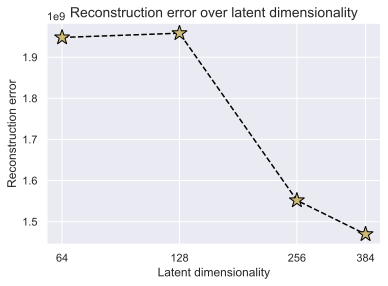

In [9]:
latent_dims = sorted([k for k in model_dict])
val_scores = [model_dict[k]["result"]["val"][0]["test_loss"] for k in latent_dims]

fig = plt.figure(figsize=(6,4))
plt.plot(latent_dims, val_scores, '--', color="#000", marker="*", markeredgecolor="#000", markerfacecolor="y", markersize=16)
plt.xscale("log")
plt.xticks(latent_dims, labels=latent_dims)
plt.title("Reconstruction error over latent dimensionality", fontsize=14)
plt.xlabel("Latent dimensionality")
plt.ylabel("Reconstruction error")
plt.minorticks_off()
plt.show()

####Display Outputs

True Spectrogram + Sound:


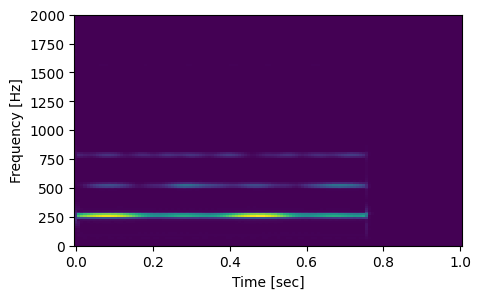


Reconstructed Spectrogram + Sound:


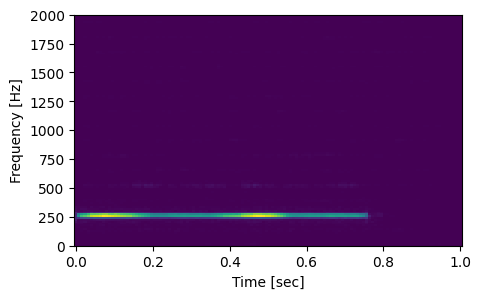




True Spectrogram + Sound:


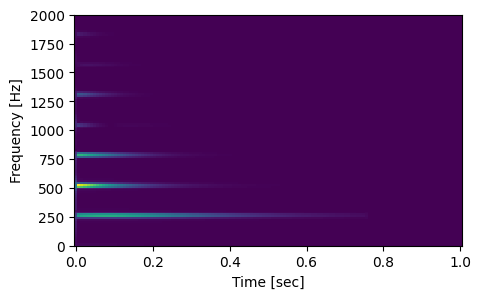


Reconstructed Spectrogram + Sound:


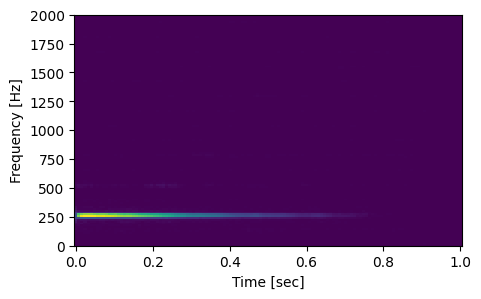




True Spectrogram + Sound:


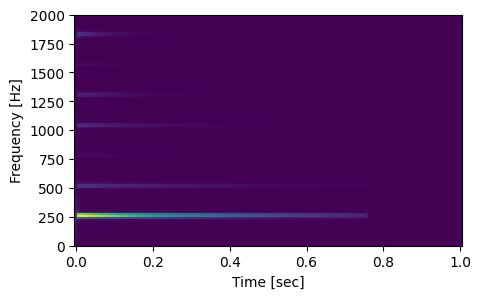


Reconstructed Spectrogram + Sound:


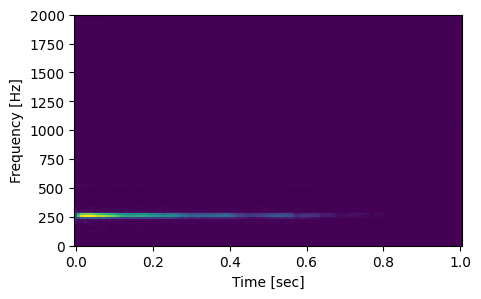




True Spectrogram + Sound:


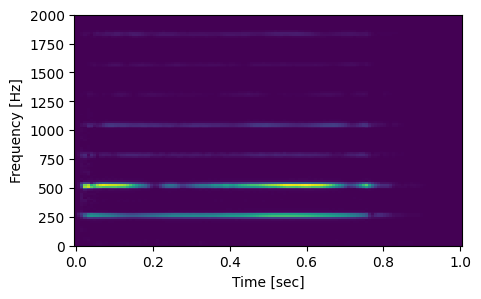


Reconstructed Spectrogram + Sound:


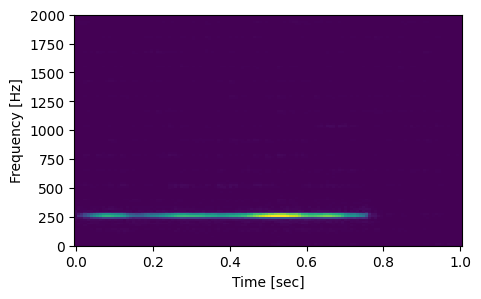

In [39]:
def visualize_reconstructions(model, input_imgs):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs = model(input_imgs.to(model.device))
    reconst_imgs = reconst_imgs.cpu()

    for i in range(len(reconst_imgs)):
        print("True Spectrogram + Sound:")
        spectrogram_true = recompose_spect(input_imgs[i][0], input_imgs[i][1])
        show_spectro(times, freqs, spectrogram_true)
        spectro_to_audio(spectrogram_true, sample_rate)

        print()
        print("Reconstructed Spectrogram + Sound:")
        spectrogram_gen = recompose_spect(reconst_imgs[i][0], reconst_imgs[i][1])
        show_spectro(times, freqs, spectrogram_gen)
        spectro_to_audio(spectrogram_gen, sample_rate)
        print()
        print("===========================================")
        print("===========================================")
        print()
        print()

input_imgs = test_dataset[0:4]

for latent_dim in model_dict:
    visualize_reconstructions(model_dict[latent_dim]["model"], input_imgs[0])

###Generate from Latent Space:

In [184]:
ls = torch.tensor(np.random.rand(48)*0.01).to(torch.double)
ls = ls.reshape([1, 48])
ls.shape

torch.Size([1, 48])

In [175]:
pred = model_dict[latent_dim]["model"].decoder(ls).detach().numpy()

spectrogram_gen = recompose_spect(pred[0][0], pred[0][1])
show_spectro(times, freqs, spectrogram_gen)
spectro_to_audio(spectrogram_gen, sample_rate)